# Kernel Learning

Kernel learning is a way to transform features in either classification or regression problems. Recall in regression, we have the following model equation:
$$
\hat{y} = \vec{w}·\vec{x} + b
$$

where $\vec{x}$ is our feature vector of dimension $D$. In kernel learning, we transform our feature vector from dimension $D$ features to distances to training data points of dimension $N$, where $N$ is the number of training data points:
$$
\hat{y}=\sum_i^N w_i \langle \vec{x},\vec{x}_i \rangle + b
$$
where $\langle · \rangle$ is distance between two feature vectors and $\vec{x}_i$ is the $i$th training data point. $\vec{x}$ is the function argument whereas $\vec{x}i$ are known values.

In kernel learning, you only need to define your *kernel function* $\langle · \rangle$ and never explicitly work with the feature vector.

A kernel function is a **binary** function taht outputs a scalar and has the following properties:
1. Positive
2. Symmetric
3. Point-separating: $\langle x, x' \rangle = 0$ iff $x=x'$

The classic kernel function example is $l_2$ norm $\langle \vec{x}, \vec{x}' \rangle = \sqrt{\sum_i^D (x_i-x_i')^2}$

When a model is written using kernel its called **Dual form**, and when its written in the standard model equation is called **Primal Form**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# import dmol

In the following lesson we go back to the solubility example

In [2]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]
np.random.seed(0)

# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

# 1. Kernel Definition

We’ll start by creating our kernel function. Our kernel function does not need to be differentiable. In contrast to the functions we see in deep learning, we can use sophisticated and non-differentiable functions in kernel learning. For example, you could use a two-component molecular dynamics simulation to compute the kernel between two molecules. We’ll still implement our kernel functions in JAX for this example because it is efficient and consistent. Remember our kernel should take two feature vectors and return a scalar. In our example, we will simply use the $l_2$ norm. I will add one small twist though: dividing by the dimension. This makes our kernel output magnitude is independent of the number of dimensions of $x$.

In [3]:
def kernel(x1, x2):
    return jnp.sqrt(jnp.mean((x1 -  x2) ** 2))

## 2. Model Definition

Now we define our regression model equation in the dual form. Remember that our function must always take the training data in to compute the distance to a new given point. We will use the batch feature of JAX to compute all the kernels simultaneously for our new point.

In [4]:
#? Pretty lost on what the jax.vmap function does and how it works...
def model(x, train_x, w, b):
    # make vectorized version of kernel
    vkernel = jax.vmap(kernel, in_axes=(None, 0), out_axes=0)
    # compute kernel with all training data
    s = vkernel(x, train_x)
    # dual form
    yhat = jnp.dot(s, w) + b
    return yhat


# make batched version that can handle multiple xs
batch_model = jax.vmap(model, in_axes=(0, None, None, None), out_axes=0)

## 3. Training

We now have trainable weights and a model equation. To begin training, we need to define a loss function and compute its gradient. We’ll use mean squared error as usual for the loss function.

In [5]:
@jax.jit
def loss(w, b, train_x, x, y):
    return jnp.mean((batch_model(x, train_x, w, b) - y) ** 2)


loss_grad = jax.grad(loss, (0, 1))


# Get 80/20 split
N = len(soldata)
train = soldata[: int(N * 0.8)]
test = soldata[int(N * 0.8) :]

# convert from pandas dataframe to numpy arrays
train_x = train[feature_names].values
train_y = train["Solubility"].values
test_x = test[feature_names].values
test_y = test["Solubility"].values

Now create the batches and create the trainable parameters

In [6]:
eta = 1e-5
batch_size = 32
epochs = 10


# reshape into batches
batch_num = train_x.shape[0] // batch_size
# first truncate data so it's whole nubmer of batches
trunc = batch_num * batch_size
train_x = train_x[:trunc]
train_y = train_y[:trunc]
# split into batches
x_batches = train_x.reshape(-1, batch_size, train_x.shape[-1])
y_batches = train_y.reshape(-1, batch_size)


# make trainable parameters
# w = np.random.normal(scale = 1e-30, size=train_x.shape[0])
w = np.zeros(train_x.shape[0])
b = np.mean(train_y)  # just set to mean, since it's a good first guess

The $\eta=10^{-5}$ is unusually low because each training data point (around 8000) contributes to the final $\hat{y}$. Thus if we take a large training step, it can create very big changes to $\hat{y}$

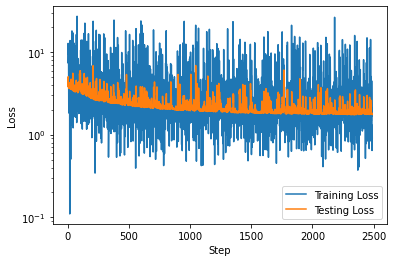

In [7]:
loss_progress = []
test_loss_progress = []

for _ in range(epochs):
    # go in random order #? WHY???
    for i in np.random.randint(0, batch_num - 1, size=batch_num):
        # 1. Get data for this batch
        x = x_batches[i]
        y = y_batches[i]
        # 2. Calculate the loss function and save it for training and testing
        loss_progress.append(loss(w, b, train_x, x, y))
        test_loss_progress.append(loss(w, b, train_x, test_x, test_y))
        # 3. Calculate gradient with the current batch
        grad = loss_grad(w, b, train_x, x, y)
        # 4. Update parameters in the direction of lower loss function
        w -= eta * grad[0]
        b -= eta * grad[1]
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

We now check the results

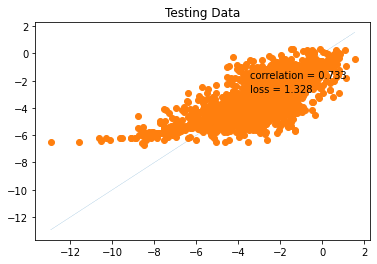

In [8]:
yhat = batch_model(test_x, train_x, w, b)
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}")
plt.title("Testing Data")
plt.show()

Now we check if performing some more epochs improve the results substantially.

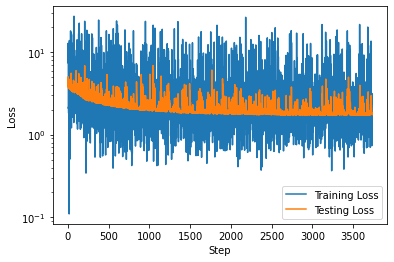

In [9]:
more_epochs = 5

for _ in range(more_epochs):
    # go in random order #? WHY???
    for i in np.random.randint(0, batch_num - 1, size=batch_num):
        # 1. Get data for this batch
        x = x_batches[i]
        y = y_batches[i]
        # 2. Calculate the loss function and save it for training and testing
        loss_progress.append(loss(w, b, train_x, x, y))
        test_loss_progress.append(loss(w, b, train_x, test_x, test_y))
        # 3. Calculate gradient with the current batch
        grad = loss_grad(w, b, train_x, x, y)
        # 4. Update parameters in the direction of lower loss function
        w -= eta * grad[0]
        b -= eta * grad[1]
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

And recheck the results

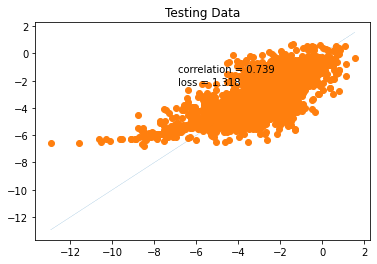

In [10]:
yhat = batch_model(test_x, train_x, w, b)
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}")
plt.title("Testing Data")
plt.show()

There is a very small improvement, but there is some.

## 4. Regularization

You’ll notice that our trainable parameter number, by design, is equal to the number training data points. If we were to use a direct computation of the fit coefficients with a pseudo-inverse, we could run into problems because of this. Thus, most people add an additional regularization term to both make matrix algebra solutions tractable and because it seems wise with the large number of trainable parameters. Just like we saw in linear regression, L1 regression is known as **Kernel Lasso Regression** and L2 is known as **Kernel Ridge Regression**. Remember that L1 zeros-out specific parameters which was useful for interpreting the importance of features in linear regression. However, in the kernel setting this would only zero-out specific training data points and thus provides no real insight. Kernel ridge regression is thus more popular in the kernel setting.

## 5. Training Curves

In this case we cannot change the number of features that we are considering to modify the bias-variance trade-off, instead the number of features depends on the number of datapoints that we use.

Therefore, usually adding more data (more features) ends up reducing test loss and it cannot be used to assess the model. What is usually done is plot the test loss as a function of data used. This plots are called **learning curves** or **training curves**

In [11]:
def fit_model(loss, npoints, eta=1e-6, batch_size=16, epochs=25):

    sample_idx = np.random.choice(
        np.arange(train_x.shape[0]), replace=False, size=npoints
    )
    sample_x = train_x[sample_idx, :]
    sample_y = train_y[sample_idx]

    # reshape into batches
    batch_num = npoints // batch_size
    # first truncate data so it's whole nubmer of batches
    trunc = batch_num * batch_size
    sample_x = sample_x[:trunc]
    sample_y = sample_y[:trunc]
    # split into batches
    x_batches = sample_x.reshape(-1, batch_size, sample_x.shape[-1])
    y_batches = sample_y.reshape(-1, batch_size)

    # get loss grad
    loss_grad = jax.grad(loss, (0, 1))

    # make trainable parameters
    # w = np.random.normal(scale = 1e-30, size=train_x.shape[0])
    w = np.zeros(sample_x.shape[0])
    b = np.mean(sample_y)  # just set to mean, since it's a good first guess
    for _ in range(epochs):
        # go in random order
        for i in np.random.randint(0, batch_num - 1, size=batch_num):
            # update step
            x = x_batches[i]
            y = y_batches[i]
            grad = loss_grad(w, b, sample_x, x, y)
            w -= eta * grad[0]
            b -= eta * grad[1]
    return loss(w, b, sample_x, test_x, test_y)


# test it out
fit_model(loss, 256)

DeviceArray(3.904821, dtype=float32)

Now we’ll create L1 and L2 version of our loss. We must choose the strength of the regularization. Since our weights are less than 1, I’ll choose much stronger regularization for the L2. These are hyperparameters though and you can adjust them to improve your fit.

In [12]:
@jax.jit
def loss_l1(w, b, train_x, x, y):
    return jnp.mean((batch_model(x, train_x, w, b) - y) ** 2) + 1e-2 * jnp.sum(
        jnp.abs(w)
    )


@jax.jit
def loss_l2(w, b, train_x, x, y):
    return jnp.mean((batch_model(x, train_x, w, b) - y) ** 2) + 1e2 * jnp.sum(w**2)

Now we can generate the points for the curves (train and test the models).

In [13]:
nvalues = [32, 256, 512, 1024, 2048, 1024 * 5]

nor_losses = [fit_model(loss, n) for n in nvalues]
l1_losses = [fit_model(loss_l1, n) for n in nvalues]
l2_losses = [fit_model(loss_l2, n) for n in nvalues]

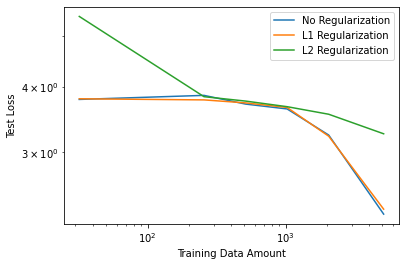

In [14]:
plt.plot(nvalues, nor_losses, label="No Regularization")
plt.plot(nvalues, l1_losses, label="L1 Regularization")
plt.plot(nvalues, l2_losses, label="L2 Regularization")
plt.legend()
plt.xlabel("Training Data Amount")
plt.ylabel("Test Loss")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

Finally, we see our training curves showing the different approaches. Regularization has some effect on final loss on the test data. It is hard to say if L1 and L2 are simply worse, or if I need to tune the regularization strength more. Nevertheless, this plot shows you how we typically evaluated kernel learning methods.

## 6. Chapter Summary

- In this section we introduced kernel learning, which is a method to transform features into distance between samples.
- A kernel function takes two arguments and outputs a scalar. A kernel function must have three properties: positive, symmetric, and point-separating.
- The distance function (inner product) is a kernel function.
- Kernel functions do not need to be differentiable.
- Kernel learning is appropriate when you would like to use features that can only be specified as a binary kernel function.
- The number of trainable parameters in a kernel model is proportional to number of training points, not dimension of features.
